In [1]:
import datetime as dt
import os
import sys

import numpy as np
import pandas as pd
from scipy import interp
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, auc, confusion_matrix, roc_curve, average_precision_score, precision_recall_curve
from sklearn.model_selection import StratifiedKFold
import sqlalchemy as sa
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('../')
from utilities import sql_utils as su
from utilities import model_eval_utils as meu

DWH = os.getenv('MIMIC_DWH')
engine = create_engine(DWH)

pd.options.display.max_columns = 1000
pd.options.display.max_rows = 1000
pd.set_option('display.float_format', lambda x: '%.3f' % x)

/Users/VincentLa/anaconda3/envs/cse6250-project/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
QUERY = """
select
  *
from datasets.model_demog_dx
"""
with engine.begin() as conn:
    df = pd.read_sql(QUERY, conn)

## Exploring The Data

In [3]:
df.head()

,hadm_id,hospital_expire_flag,is_male,age_at_admit,admission_type,insurance,language,marital_status,ethnicity,ccs_0,ccs_1,ccs_2,ccs_3,ccs_4,ccs_5,ccs_6,ccs_7,ccs_8,ccs_9,ccs_10,ccs_11,ccs_12,ccs_13,ccs_14,ccs_15,ccs_16,ccs_17,ccs_18,ccs_19,ccs_20,ccs_21,ccs_22,ccs_23,ccs_24,ccs_25,ccs_26,ccs_27,ccs_28,ccs_29,ccs_30,ccs_31,ccs_32,ccs_33,ccs_34,ccs_35,ccs_36,ccs_37,ccs_38,ccs_39,ccs_40,ccs_41,ccs_42,ccs_43,ccs_44,ccs_45,ccs_46,ccs_47,ccs_48,ccs_49,ccs_50,ccs_51,ccs_52,ccs_53,ccs_54,ccs_55,ccs_56,ccs_57,ccs_58,ccs_59,ccs_60,ccs_61,ccs_62,ccs_63,ccs_64,ccs_65,ccs_66,ccs_67,ccs_68,ccs_69,ccs_70,ccs_71,ccs_72,ccs_73,ccs_74,ccs_75,ccs_76,ccs_77,ccs_78,ccs_79,ccs_80,ccs_81,ccs_82,ccs_83,ccs_84,ccs_85,ccs_86,ccs_87,ccs_88,ccs_89,ccs_90,ccs_91,ccs_92,ccs_93,ccs_94,ccs_95,ccs_96,ccs_97,ccs_98,ccs_99,ccs_100,ccs_101,ccs_102,ccs_103,ccs_104,ccs_105,ccs_106,ccs_107,ccs_108,ccs_109,ccs_110,ccs_111,ccs_112,ccs_113,ccs_114,ccs_115,ccs_116,ccs_117,ccs_118,ccs_119,ccs_120,ccs_121,ccs_122,ccs_123,ccs_124,ccs_125,ccs_126,ccs_127,ccs_128,ccs_129,ccs_130,ccs_131,ccs_132,ccs_133,ccs_134,ccs_135,ccs_136,ccs_137,ccs_138,ccs_139,ccs_140,ccs_141,ccs_142,ccs_143,ccs_144,ccs_145,ccs_146,ccs_147,ccs_148,ccs_149,ccs_150,ccs_151,ccs_152,ccs_153,ccs_154,ccs_155,ccs_156,ccs_157,ccs_158,ccs_159,ccs_160,ccs_161,ccs_162,ccs_163,ccs_164,ccs_165,ccs_166,ccs_167,ccs_168,ccs_169,ccs_170,ccs_171,ccs_172,ccs_173,ccs_174,ccs_175,ccs_176,ccs_177,ccs_178,ccs_179,ccs_180,ccs_181,ccs_182,ccs_183,ccs_184,ccs_185,ccs_186,ccs_187,ccs_188,ccs_189,ccs_190,ccs_191,ccs_192,ccs_193,ccs_194,ccs_195,ccs_196,ccs_197,ccs_198,ccs_199,ccs_200,ccs_201,ccs_202,ccs_203,ccs_204,ccs_205,ccs_206,ccs_207,ccs_208,ccs_209,ccs_210,ccs_211,ccs_212,ccs_213,ccs_214,ccs_215,ccs_216,ccs_217,ccs_218,ccs_219,ccs_220,ccs_221,ccs_222,ccs_223,ccs_224,ccs_225,ccs_226,ccs_227,ccs_228,ccs_229,ccs_230,ccs_231,ccs_232,ccs_233,ccs_234,ccs_235,ccs_236,ccs_237,ccs_238,ccs_239,ccs_240,ccs_241,ccs_242,ccs_243,ccs_244,ccs_245,ccs_246,ccs_247,ccs_248,ccs_249,ccs_250,ccs_251,ccs_252,ccs_253,ccs_254,ccs_255,ccs_256,ccs_257,ccs_258,ccs_259,ccs_260,ccs_261,ccs_262,ccs_263,ccs_264,ccs_265,ccs_266,ccs_267,ccs_268,ccs_269,ccs_270,ccs_271,ccs_272,ccs_273,ccs_274,ccs_275,ccs_276,ccs_277,ccs_278,ccs_279,ccs_280,ccs_281
0,155385,0,1,71.000,EMERGENCY,Private,ENGL,MARRIED,UNKNOWN/NOT SPECIFIED,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,125288,0,0,38.000,EMERGENCY,Medicaid,ENGL,SINGLE,BLACK/AFRICAN AMERICAN,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,158943,0,0,45.000,EMERGENCY,Medicaid,ENGL,SINGLE,BLACK/AFRICAN AMERICAN,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0

In [4]:
df.hospital_expire_flag.value_counts()

0    53122
1     5854
Name: hospital_expire_flag, dtype: int64

In [5]:
df.groupby('insurance').describe()

age_at_admit                                                     \
                  count    mean    std   min    25%    50%     75%     max   
insurance                                                                    
Government     1783.000  51.040 31.229 0.000 34.000 59.000  74.000 300.000   
Medicaid       5785.000  54.315 35.185 0.000 37.000 63.000  77.000 316.000   
Medicare      28215.000 110.950 62.522 0.000 84.000 95.000 106.000 344.000   
Private       22582.000  53.005 38.306 0.000  0.000 65.000  80.000 342.000   
Self Pay        611.000  59.820 31.641 0.000 46.000 60.000  74.000 300.000   

               ccs_0                                               ccs_1  \
               count  mean   std   min   25%   50%   75%   max     count   
insurance                                                                  
Government  1783.000 0.034 0.180 0.000 0.000 0.000 0.000 1.000  1783.000   
Medicaid    5785.000 0.046 0.209 0.000 0.000 0.000 0.000 1.000  5785.000   
Medicare   28215.000 0.055 0.229 0.000 0.000 0.000 0.000 1.000 28215.000   
Private    22582.000 0.052 0.222 0.000 0.000 0.000 0.000 1.000 22582.000   
Self Pay     611.000 0.026 0.160 0.000 0.000 0.000 0.000 1.000   611.000   

                                                        ccs_10              \
            mean   std   min   25%   50%   75%   max     count  mean   std   
insurance                                                                    
Government 0.011 0.105 0.000 0.000 0.000 0.000 1.000  1783.000 0.148 0.355   
Medicaid   0.020 0.138 0.000 0.000 0.000 0.000 1.000  5785.000 0.199 0.399   
Medicare   0.033 0.178 0.000 0.000 0.000 0.000 1.000 28215.000 0.253 0.435   
Private    0.020 0.141 0.000 0.000 0.000 0.000 1.000 22582.000 0.133 0.339   
Self Pay   0.011 0.107 0.000 0.000 0.000 0.000 1.000   611.000 0.147 0.355   

                                           ccs_100                          \
             min   25%   50%   75%   max     count  mean   std   min   25%   
insurance                                                                    
Government 0.000 0.000 0.000 0.000 1.000  1783.000 0.008 0.091 0.000 0.000   
Medicaid   0.000 0.000 0.000 0.000 1.000  5785.000 0.012 0.109 0.000 0.000   
Medicare   0.000 0.000 0.000 1.000 1.000 28215.000 0.006 0.079 0.000 0.000   
Private    0.000 0.000 0.000 0.000 1.000 22582.000 0.019 0.136 0.000 0.000   
Self Pay   0.000 0.000 0.000 0.000 1.000   611.000 0.023 0.150 0.000 0.000   

                               ccs_101                                      \
             50%   75%   max     count  mean   std   min   25%   50%   75%   
insurance                                                                    
Government 0.000 0.000 1.000  1783.000 0.022 0.148 0.000 0.000 0.000 0.000   
Medicaid   0.000 0.000 1.000  5785.000 0.016 0.124 0.000 0.000 0.000 0.000   
Medicare   0.000 0.000 1.000 28215.000 0.006 0.075 0.000 0.000 0.000 0.000   
Private    0.000 0.000 1.000 22582.000 0.016 0.127 0.000 0.000 0.000 0.000   
Self Pay   0.000 0.000 1.000   611.000 0.062 0.242 0.000 0.000 0.000 0.000   

                   ccs_102                                            \
             max     count  mean   std   min   25%   50%   75%   max   
insurance                                                              
Government 1.000  1783.000 0.004 0.063 0.000 0.000 0.000 0.000 1.000   
Medicaid   1.000  5785.000 0.004 0.067 0.000 0.000 0.000 0.000 1.000   
Medicare   1.000 28215.000 0.002 0.041 0.000 0.000 0.000 0.000 1.000   
Private    1.000 22582.000 0.005 0.074 0.000 0.000 0.000 0.000 1.000   
Self Pay   1.000   611.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000   

             ccs_103                                             ccs_104  \
               count  mean   std   min   25%   50%   75%   max     count   
insurance                                                                  
Government  1783.000 0.067 0.251 0.000 0.000 0.000 0.000 1.000  1783.000   
Medicaid    5785.000 

## Machine Learning

### Data Pre-Processing

In [6]:
def split_dataset(dataset, train_percentage, feature_headers, target_header):
    """
    Split the dataset with train_percentage
    
    Keyword Args:
    dataset: The Actual Dataset
    train_percentage: Percentage of Dataset to split into Training
    feature_headers: columns that are features to include
    target_header: column that is the outcome variable of interest
    :return: train_x, test_x, train_y, test_y
    """

    # Split dataset into train and test dataset
    train_x, test_x, train_y, test_y = train_test_split(dataset[feature_headers],
                                                        dataset[target_header],
                                                        train_size=train_percentage)
    return train_x, test_x, train_y, test_y

In [7]:
admission_type_dummies = \
    pd.get_dummies(df.admission_type, prefix='admission_type', dummy_na=True)
insurance_dummies = \
    pd.get_dummies(df.insurance, prefix='insurance', dummy_na=True)
language_dummies = \
    pd.get_dummies(df.language, prefix='language', dummy_na=True)
marital_dummies = \
    pd.get_dummies(df.marital_status, prefix='marital', dummy_na=True)
ethnicity_dummies = \
    pd.get_dummies(df.ethnicity, prefix='ethnicity', dummy_na=True)

In [8]:
df_model = pd.concat([df, admission_type_dummies, insurance_dummies,
                     language_dummies, marital_dummies, ethnicity_dummies], axis=1)

In [9]:
df_model.head()

,hadm_id,hospital_expire_flag,is_male,age_at_admit,admission_type,insurance,language,marital_status,ethnicity,ccs_0,ccs_1,ccs_2,ccs_3,ccs_4,ccs_5,ccs_6,ccs_7,ccs_8,ccs_9,ccs_10,ccs_11,ccs_12,ccs_13,ccs_14,ccs_15,ccs_16,ccs_17,ccs_18,ccs_19,ccs_20,ccs_21,ccs_22,ccs_23,ccs_24,ccs_25,ccs_26,ccs_27,ccs_28,ccs_29,ccs_30,ccs_31,ccs_32,ccs_33,ccs_34,ccs_35,ccs_36,ccs_37,ccs_38,ccs_39,ccs_40,ccs_41,ccs_42,ccs_43,ccs_44,ccs_45,ccs_46,ccs_47,ccs_48,ccs_49,ccs_50,ccs_51,ccs_52,ccs_53,ccs_54,ccs_55,ccs_56,ccs_57,ccs_58,ccs_59,ccs_60,ccs_61,ccs_62,ccs_63,ccs_64,ccs_65,ccs_66,ccs_67,ccs_68,ccs_69,ccs_70,ccs_71,ccs_72,ccs_73,ccs_74,ccs_75,ccs_76,ccs_77,ccs_78,ccs_79,ccs_80,ccs_81,ccs_82,ccs_83,ccs_84,ccs_85,ccs_86,ccs_87,ccs_88,ccs_89,ccs_90,ccs_91,ccs_92,ccs_93,ccs_94,ccs_95,ccs_96,ccs_97,ccs_98,ccs_99,ccs_100,ccs_101,ccs_102,ccs_103,ccs_104,ccs_105,ccs_106,ccs_107,ccs_108,ccs_109,ccs_110,ccs_111,ccs_112,ccs_113,ccs_114,ccs_115,ccs_116,ccs_117,ccs_118,ccs_119,ccs_120,ccs_121,ccs_122,ccs_123,ccs_124,ccs_125,ccs_126,ccs_127,ccs_128,ccs_129,ccs_130,ccs_131,ccs_132,ccs_133,ccs_134,ccs_135,ccs_136,ccs_137,ccs_138,ccs_139,ccs_140,ccs_141,ccs_142,ccs_143,ccs_144,ccs_145,ccs_146,ccs_147,ccs_148,ccs_149,ccs_150,ccs_151,ccs_152,ccs_153,ccs_154,ccs_155,ccs_156,ccs_157,ccs_158,ccs_159,ccs_160,ccs_161,ccs_162,ccs_163,ccs_164,ccs_165,ccs_166,ccs_167,ccs_168,ccs_169,ccs_170,ccs_171,ccs_172,ccs_173,ccs_174,ccs_175,ccs_176,ccs_177,ccs_178,ccs_179,ccs_180,ccs_181,ccs_182,ccs_183,ccs_184,ccs_185,ccs_186,ccs_187,ccs_188,ccs_189,ccs_190,ccs_191,ccs_192,ccs_193,ccs_194,ccs_195,ccs_196,ccs_197,ccs_198,ccs_199,ccs_200,ccs_201,ccs_202,ccs_203,ccs_204,ccs_205,ccs_206,ccs_207,ccs_208,ccs_209,ccs_210,ccs_211,ccs_212,ccs_213,ccs_214,ccs_215,ccs_216,ccs_217,ccs_218,ccs_219,ccs_220,ccs_221,ccs_222,ccs_223,ccs_224,ccs_225,ccs_226,ccs_227,ccs_228,ccs_229,ccs_230,ccs_231,ccs_232,ccs_233,ccs_234,ccs_235,ccs_236,ccs_237,ccs_238,ccs_239,ccs_240,ccs_241,ccs_242,ccs_243,ccs_244,ccs_245,ccs_246,ccs_247,ccs_248,ccs_249,ccs_250,ccs_251,ccs_252,ccs_253,ccs_254,ccs_255,ccs_256,ccs_257,ccs_258,ccs_259,ccs_260,ccs_261,ccs_262,ccs_263,ccs_264,ccs_265,ccs_266,ccs_267,ccs_268,ccs_269,ccs_270,ccs_271,ccs_272,ccs_273,ccs_274,ccs_275,ccs_276,ccs_277,ccs_278,ccs_279,ccs_280,ccs_281,admission_type_ELECTIVE,admission_type_EMERGENCY,admission_type_NEWBORN,admission_type_URGENT,admission_type_nan,insurance_Government,insurance_Medicaid,insurance_Medicare,insurance_Private,insurance_Self Pay,insurance_nan,language_* BE,language_* FU,language_** T,language_**SH,language_**TO,language_*AMH,language_*ARA,language_*ARM,language_*BEN,language_*BOS,language_*BUL,language_*BUR,language_*CAN,language_*CDI,language_*CHI,language_*CRE,language_*DEA,language_*DUT,language_*FAR,language_*FIL,language_*FUL,language_*GUJ,language_*HUN,language_*IBO,language_*KHM,language_*LEB,language_*LIT,language_*MAN,language_*MOR,language_*NEP,language_*PER,language_*PHI,language_*PUN,language_*ROM,language_*RUS,language_*SPA,language_*TAM,language_*TEL,language_*TOI,language_*TOY,language_*URD,language_*YID,language_*YOR,language_ALBA,language_AMER,language_ARAB,language_BENG,language_CAMB,language_CANT,language_CAPE,language_ENGL,language_ETHI,language_FREN,language_GERM,language_GREE,language_HAIT,language_HIND,language_ITAL,language_JAPA,language_KORE,language_LAOT,language_MAND,language_PERS,language_POLI,language_PORT,language_PTUN,language_RUSS,language_SERB,language_SOMA,language_SPAN,language_TAGA,language_THAI,language_TURK,language_URDU,language_VIET,language_nan,marital_DIVORCED,marital_LIFE PARTNER,marital_MARRIED,marital_SEPARATED,marital_SINGLE,marital_UNKNOWN (DEFAULT),marital_WIDOWED,marital_nan,ethnicity_AMERICAN INDIAN/ALASKA NATIVE,ethnicity_AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE,ethnicity_ASIAN,ethnicity_ASIAN - ASIAN INDIAN,ethnicity_ASIAN - CAMBODIAN,ethnicity_ASIAN - CHINESE,ethnicity_ASIAN - FILIPINO,ethnicity_ASIAN - JAPANESE,ethnicity_ASIAN - KOREAN,ethnicity_ASIAN - OTHER,ethnic

In [21]:
target_header = 'hospital_expire_flag'
demog_features = ['is_male',
                  'age_at_admit',
                 ]
ccs_features = [c for c in df.columns if 'ccs' in c]
feature_headers = list(admission_type_dummies.columns) +\
                  list(insurance_dummies.columns) +\
                  list(language_dummies.columns) +\
                  list(marital_dummies.columns) +\
                  list(ethnicity_dummies.columns) +\
                  demog_features + ccs_features
X = df_model.loc[:, feature_headers]
y = df_model.hospital_expire_flag
train_x, test_x, train_y, test_y = split_dataset(df_model, 0.7, feature_headers, target_header)

/Users/VincentLa/anaconda3/envs/cse6250-project/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [22]:
# Train and Test dataset size details
print("Train_x Shape :: ", train_x.shape)
print("Train_y Shape :: ", train_y.shape)
print("Test_x Shape :: ", test_x.shape)
print("Test_y Shape :: ", test_y.shape)

Train_x Shape ::  (41283, 421)
Train_y Shape ::  (41283,)
Test_x Shape ::  (17693, 421)
Test_y Shape ::  (17693,)


### Random Forest Classifier

In [23]:
clf = RandomForestClassifier()
trained_model = clf.fit(train_x, train_y)

#### Evaluation

In [24]:
# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=6)

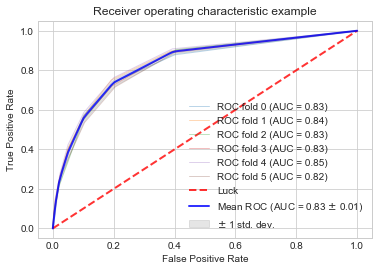

In [25]:
# Creating ROC Curve with Cross Validation
meu.draw_cv_roc_curve(clf, cv, train_x, train_y)

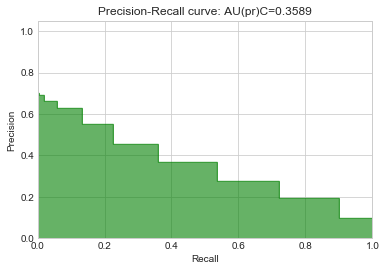

In [26]:
# Plotting Precision Recall Curve
meu.plot_precision_recall_curve(clf, test_x, test_y)

In [27]:
predictions = trained_model.predict(test_x)

In [28]:
# Train and Test Accuracy
print("Train Accuracy :: ", accuracy_score(train_y, trained_model.predict(train_x)))
print("Test Accuracy  :: ", accuracy_score(test_y, predictions))
print(" Confusion matrix ", confusion_matrix(test_y, predictions))

Train Accuracy ::  0.9750260397742412
Test Accuracy  ::  0.9087774826202453
 Confusion matrix  [[15851   133]
 [ 1481   228]]


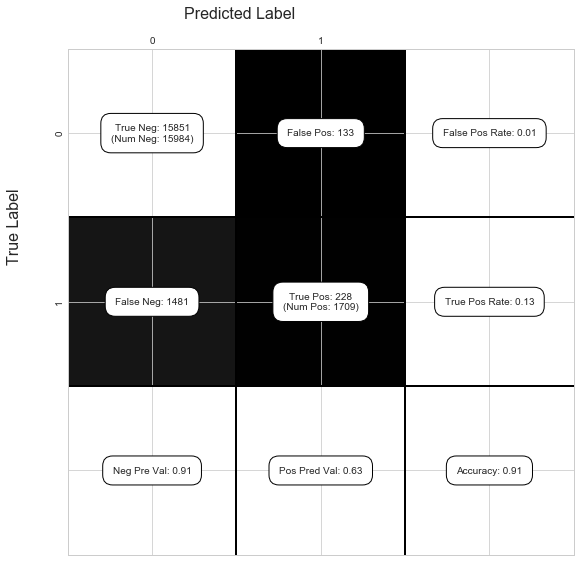

In [29]:
meu.show_confusion_matrix(confusion_matrix(test_y, predictions))

#### Feature Importances

In [30]:
importances = trained_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in trained_model.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

#for f in range(train_x.shape[1]):
for f in range(25): 
    column = train_x.columns[indices[f]]
    print("{ranking}. feature {column} ({importance})".format(ranking=f+1,
                                                             column=column,
                                                             importance=importances[indices[f]]))

Feature ranking:
1. feature age_at_admit (0.05879879129934571)
2. feature ccs_10 (0.03506281265274119)
3. feature ccs_246 (0.029693423076997533)
4. feature ccs_39 (0.028752724924031203)
5. feature ccs_4 (0.022017933860573314)
6. feature ccs_243 (0.021139064938919427)
7. feature ccs_7 (0.016049458803068926)
8. feature is_male (0.013618615282911214)
9. feature language_nan (0.013575024956564463)
10. feature ccs_197 (0.013205939473788179)
11. feature ccs_97 (0.012922951037812547)
12. feature ccs_227 (0.011821800364646227)
13. feature ccs_64 (0.011811348810966515)
14. feature language_ENGL (0.011427348789356183)
15. feature marital_MARRIED (0.011354488120219258)
16. feature ccs_53 (0.011265392993406668)
17. feature ccs_112 (0.011190066270854258)
18. feature ethnicity_WHITE (0.01008207235632586)
19. feature ccs_169 (0.010071101707432962)
20. feature ccs_59 (0.009983496730962101)
21. feature ccs_46 (0.009822252042831964)
22. feature ccs_15 (0.009680480377078129)
23. feature ccs_277 (0.009201

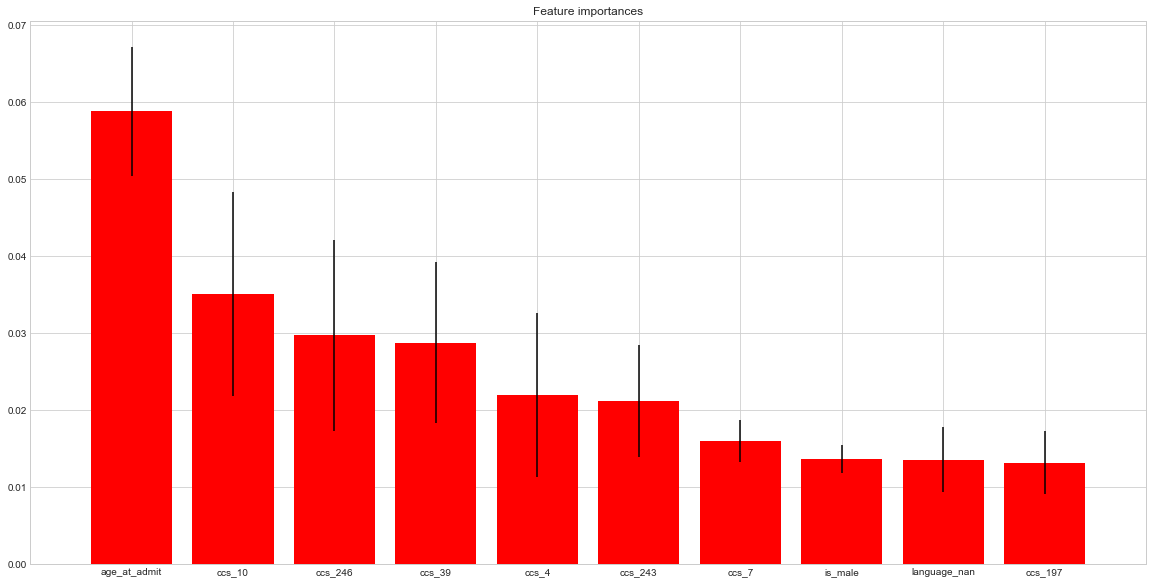

In [31]:
# Plot the feature importances of the forest
top_features = 10
plt.figure(figsize=(20, 10))
plt.title("Feature importances")
plt.bar(range(top_features),
        importances[indices[0:top_features]],
        color="r",
        yerr=std[indices[0:top_features]],
        align="center")
plt.xticks(range(top_features), train_x.columns[indices[0:top_features]])
plt.xlim([-1, top_features])
plt.show()